In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from numpy import *
from IPython.html.widgets import *
from IPython.display import display
import matplotlib.pyplot as plt
from IPython.core.display import clear_output

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
%%javascript
/* 
Install with
sudo ipython install-nbextension https://bitbucket.org/ipre/calico/downloads/calico-document-tools-1.0.zip

and do citations like

[CITE](#cite-PER-GRA:2007)
*/
IPython.load_extensions('calico-document-tools');

<IPython.core.display.Javascript object>

<!--bibtex

@incollection{LeCun:2012vf,
author = {LeCun, Yann A and Bottou, Leon and Orr, Genevieve B and Muller, Klaus-Robert},
title = {{Efficient backprop}},
booktitle = {Neural Networks: tricks of the trade},
year = {2012},
pages = {9--48},
publisher = {Springer}
}

-->

# Neural Network Tricks

In this notebook, I'll show the effects of various techniques ("tricks") used to improve the performance of neural networks.  Most of them come from the <a name="ref-1"/>[(LeCun, Bottou, Orr and Muller, 2012)](#cite-LeCun:2012vf) paper.

Previously, we built a basic neural network in the "Backprop Exercise" notebook.  Here, I'll use a slightly refactored version of the `NeuralNetwork` class:

In [3]:
%pycat neural_network.py

In [43]:
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split, ShuffleSplit 
from sklearn.preprocessing import OneHotEncoder
from neural_network import NeuralNetwork

# The classifier network
class ClassifierNetwork(NeuralNetwork):
    """Neural network with classification error plots."""
    def errors_for(self, t, x):
        x, t = self.preprocessed(x, t)
        y = self.predictions_for(x)
        mse = multiply(y-t,y-t).mean()
        mce = (y.argmax(axis=1) != t.argmax(axis=1)).mean()
        return mse, mce

    def train_classifier(self, dataset, fig=None, ax=None, epochs=1000):
        """Perform the classification task for the data using the given network, without using train-test split."""
        X, T = dataset.data, dataset.target
        _X, _T = self.preprocessed(X, T)

        errors=[]    
        for epoch in range(epochs):
            self.update_weights(_T, _X)
            errors.append(self.errors_for(T, X))

            if fig is not None and mod(epoch+1, 100) == 0:
                aerrors=array(errors).T
                self.plot_errors(ax, aerrors.T, epoch, epochs, ylabel='Errors', ylim=3.0)
                ax.legend(['RMSE', 'RMCE'], loc='ba')
                clear_output(wait=True)
                display(fig)
                ax.cla()
            
            if errors[-1][1] == 0:  # Perfect classification
                break

        plt.close()    
        return errors[-1]    

    def plot_errors(self, ax, errors, epoch, epochs, ylabel, ylim=1.0):
        """Plots the error graph."""
        ax.plot(arange(epoch), errors[:epoch])
        ax.set_xlim([0, epochs])
        ax.set_ylim([0, ylim])
        ax.set_xlabel("Training epoch")
        ax.set_ylabel(ylabel)
        ax.set_title(ylabel)
        ax.grid()
        ax.legend(['Training', 'Test'], loc="best")      

        
class ClassifierNetworkWithOneHot(ClassifierNetwork):
    """Encodes target values using one-hot encoding."""
    def preprocessed(self, X, T=None):
        if T is not None:
            if not hasattr(self, 'encoder'):
                self.encoder = OneHotEncoder(sparse=False).fit(T[:,newaxis])
            T = self.encoder.transform(T[:,newaxis])*2 - 1
        return super(ClassifierNetworkWithOneHot, self).preprocessed(X, T)

    
# Classifier with PCA preprocessing
class ClassifierNetworkForImages(ClassifierNetworkWithOneHot):
    """Applies PCA to the input data."""
    
    def preprocessed(self, X, T=None):
        if not hasattr(self, 'pca'):
            self.pca = PCA(n_components = self.num_nodes[0], whiten=True, copy=True).fit(X)
        return super(ClassifierNetworkForImages, self).preprocessed(self.pca.transform(X),T)
    
    def train_classifier(self, dataset, fig=None, axs=None, epochs=1000, batch_size=0.1, test_size=0.2):
        """Perform the classification task for the data using the given network."""

        # Split to training and test
        X_train, X_test, T_train, T_test = train_test_split(dataset.data, dataset.target, test_size=test_size)

        errors=[]
        for epoch, epochs in self.train(X_train, T_train, epochs=epochs, batch_size=batch_size):
            errors.append(self.errors_for(T_train, X_train) + self.errors_for(T_test, X_test))

            if fig is not None and mod(epoch+1, 100) == 0:
                aerrors=array(errors).T
                self.plot_errors(axs[0], aerrors[::2].T, epoch, epochs, ylabel='RMSE', ylim=3.0)
                self.plot_errors(axs[1], aerrors[1::2].T,epoch, epochs, ylabel='Classification Error', ylim=1.0)
                clear_output(wait=True)
                display(fig)
                [ax.cla() for ax in axs]

        plt.close()    
        train_rmse, train_rce, test_rmse, test_rce = errors[-1]
        return train_rmse, test_rmse, train_rce, test_rce

Here are some datasets we'll be using:

In [5]:
from sklearn.datasets.base import Bunch
from sklearn.datasets import load_digits

# The XOR dataset
dataset_xor = Bunch()
dataset_xor['data'] = array([
    [ 1,-1],
    [-1, 1],
    [ 1, 1],
    [-1,-1]], dtype=float)
dataset_xor['target'] = array([
    1,
    1,
    0,
    0], dtype=float)

dataset_digits=load_digits()

Now let's see how the "basic" network does for these tasks.

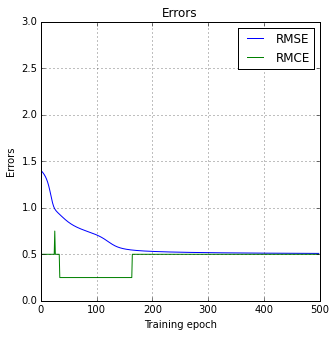

(0.50954145294780395, 0.5)


In [44]:
base_xor_net = ClassifierNetworkWithOneHot(num_nodes=[2, 2, 2])
print(base_xor_net.train_classifier(dataset_xor, *plt.subplots(figsize=(5,5)), epochs=500))

Note that the network often gets stuck in a local minimum.

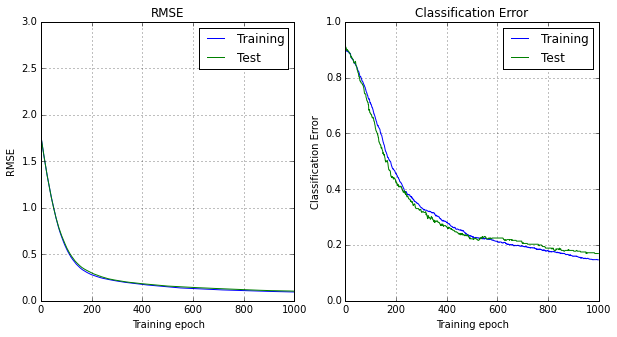

(0.094691887848109557, 0.10358034768414033, 0.14683368128044538, 0.16944444444444445)


In [7]:
base_digits_net = ClassifierNetworkForImages(num_nodes=[20, 20, 10])
print(base_digits_net.train_classifier(dataset_digits, *plt.subplots(1, 2, figsize=(10,5)), epochs=1000))

# Activation function

Let's try the "funny tanh" as the activation function.  For the XOR dataset, this ameliorates the problem of the network getting stuck in the local minimum.

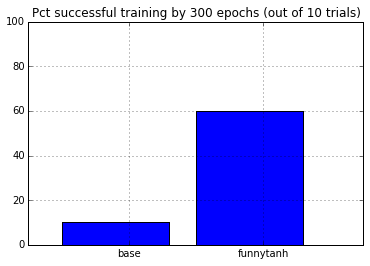

In [45]:
from neural_network import ActivationFunction

class FunnyTanh(ActivationFunction):
    def apply(self, x):
        return 1.7159 * tanh(x*2/3) + 0.001 * x

funnytanh_xor_net = ClassifierNetworkWithOneHot(num_nodes=[2, 2, 2], activation_function=FunnyTanh())
    
# Train 10 times and see how many times it gets stuck
results=zeros((10,2))
epochs=300
for result in results:
    Ws = base_xor_net.initial_weights() # keep the same initial weights
    base_xor_net.Ws = Ws
    funnytanh_xor_net.Ws = Ws
    result[0]=base_xor_net.train_classifier(dataset_xor, epochs=epochs)[1]  
    result[1]=funnytanh_xor_net.train_classifier(dataset_xor, epochs=epochs)[1]

plt.bar(arange(2), (results<1e-8).mean(axis=0) * 100.0)
plt.xticks(arange(2)+.5, ['base', 'funnytanh'])
plt.xlim([-.25, 2.25])
plt.ylim([0, 100.0])
plt.grid()
plt.title('Pct successful training by %d epochs (out of %d trials)'% (epochs, results.shape[0]))
None

# Better initial weights

Let's change the initial random weights to have standard deviation of $1/\sqrt m$, where $m$ is the number of connection feeding *into* the node.

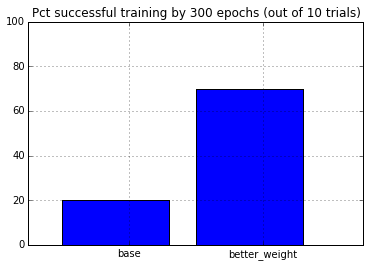

In [9]:
def better_initial_weights(self):
    return [standard_normal((n + 1, m)) / sqrt(n + 1) for n, m in zip(self.num_nodes[:-1], self.num_nodes[1:])]

better_weight_xor_net = ClassifierNetworkWithOneHot(num_nodes=[2, 2, 2])

# Train 10 times and see how many times it gets stuck
results=zeros((10,2))
epochs=300
for result in results:
    base_xor_net.Ws = base_xor_net.initial_weights()
    better_weight_xor_net.Ws = better_initial_weights(better_weight_xor_net)
    result[0]=base_xor_net.train_classifier(dataset_xor, epochs=epochs)[1]  
    result[1]=better_weight_xor_net.train_classifier(dataset_xor, epochs=epochs)[1]

plt.bar(arange(2), (results<1e-8).mean(axis=0) * 100.0)
plt.xticks(arange(2)+.5, ['base', 'better_weight'])
plt.xlim([-.25, 2.25])
plt.ylim([0, 100.0])
plt.grid()
plt.title('Pct successful training by %d epochs (out of %d trials)'% (epochs, results.shape[0]))
None

# Momentum 

Let's add the momentum to the stochastic gradient update.  Now, instead of updating the weights as

$$
W \leftarrow W - \eta \frac{\partial E}{\partial W}
$$

We will keep the *previous weight update* $V$ and *momentum* $\mu$ so that:

$$
\begin{align*}
    V &\leftarrow \mu V - \eta \frac{\partial E}{\partial W} \\
    W   &\leftarrow W + V
\end{align*}
$$

The *momentum* $\mu$ modulates how much of the previous weight update is reflected in the current update. 

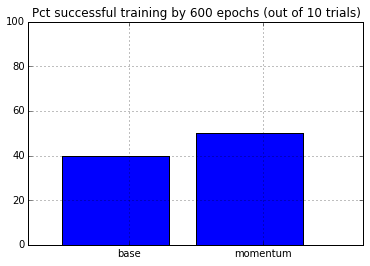

In [33]:
from neural_network import _with_bias

class ClassifierNetworkWithMomentum(ClassifierNetworkWithOneHot):
    def __init__(self, *args, **kwargs):
        super(ClassifierNetworkWithMomentum, self).__init__(*args, **kwargs)
        self.momentum = kwargs['momentum'] if kwargs.has_key('momentum') else 0.9
        self.Vs = [zeros(W.shape) for W in self.Ws]
    
    def gradient_descent(self, deltas, zs):
        N = zs[0].shape[0]
        Js= [self.eta * dot(_with_bias(z).T, delta) / N for W, z, delta in zip(self.Ws, zs[:-1], deltas)]
        self.Vs = [self.momentum * V - J for V, J in zip(self.Vs, Js)]
        return [W + V for W, V in zip(self.Vs, self.Ws)]

momentum_xor_net = ClassifierNetworkWithMomentum(num_nodes=[2, 2, 2], eta=0.05)
#print(momentum_xor_net.train_classifier(dataset_xor, *plt.subplots(figsize=(5,5)), epochs=500))

# Train 10 times and see how many times it gets stuck
results=zeros((10,2))
epochs=600
for result in results:
    Ws = base_xor_net.initial_weights()
    base_xor_net.Ws = Ws
    momentum_xor_net.Ws = Ws
    result[0]=base_xor_net.train_classifier(dataset_xor, epochs=epochs)[1]  
    result[1]=momentum_xor_net.train_classifier(dataset_xor, epochs=epochs)[1]

plt.bar(arange(2), (results<1e-8).mean(axis=0) * 100.0)
plt.xticks(arange(2)+.5, ['base', 'momentum'])
plt.xlim([-.25, 2.25])
plt.ylim([0, 100.0])
plt.grid()
plt.title('Pct successful training by %d epochs (out of %d trials)'% (epochs, results.shape[0]))
None

# Pre-train using autoencoder

We'll first perform an "unsupervised learning" using an auto-encoder: instead of predicting the target values, we'll train it to predict the input values.

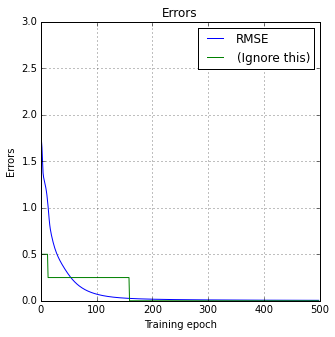

(0.0050832790738903639, 0.0)


In [36]:
class AutoEncoderNetwork(ClassifierNetwork):
    def train_unsupervised(self, dataset, fig=None, ax=None, epochs=1000):
        """Perform unsupervised learning from the data."""
        X = self.preprocessed(dataset.data)
        T = X.copy()

        errors=[]    
        for epoch in range(epochs):
            self.update_weights(T, X)
            errors.append(self.errors_for(T, X))

            if fig is not None and mod(epoch+1, 100) == 0:
                aerrors=array(errors).T
                self.plot_errors(ax, aerrors.T, epoch, epochs, ylabel='Errors', ylim=3.0)
                ax.legend(['RMSE', '(Ignore this)'], loc='ba')
                clear_output(wait=True)
                display(fig)
                ax.cla()

        plt.close()    
        return errors[-1]  

ae_xor_net = AutoEncoderNetwork(num_nodes=[2, 2, 2])
print(ae_xor_net.train_unsupervised(dataset_xor, *plt.subplots(figsize=(5,5)), epochs=500))

Then, we'd train the classifier network starting from the hidden weights that was learned.

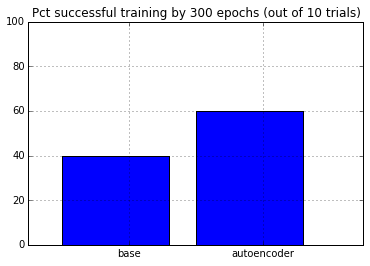

In [37]:
ae_xor_net = AutoEncoderNetwork(num_nodes=[2, 2, 2])
aeweight_xor_net = ClassifierNetworkWithOneHot(num_nodes=[2, 2, 2], activation_function=FunnyTanh())

# Train 10 times and see how many times it gets stuck
results=zeros((10,2))
epochs=300
for result in results:
    Ws = base_xor_net.initial_weights()
    base_xor_net.Ws = Ws
    
    ae_xor_net.Ws = ae_xor_net.initial_weights()
    ae_xor_net.train_unsupervised(dataset_xor, epochs=100) # Only train for a short amount
    Wh = ae_xor_net.Ws[0]

    aeweight_xor_net.Ws = [W.copy() for W in Ws]
    aeweight_xor_net.Ws[0] = Wh
    
    result[0]=base_xor_net.train_classifier(dataset_xor, epochs=epochs)[1]  
    result[1]=aeweight_xor_net.train_classifier(dataset_xor, epochs=epochs)[1]

plt.bar(arange(2), (results<1e-8).mean(axis=0) * 100.0)
plt.xticks(arange(2)+.5, ['base', 'autoencoder'])
plt.xlim([-.25, 2.25])
plt.ylim([0, 100.0])
plt.grid()
plt.title('Pct successful training by %d epochs (out of %d trials)'% (epochs, results.shape[0]))
None

# Putting everything together

Now we'll combine all of the techniques above. We'll also run it longer (1000 epochs) to see if 

In [46]:
class ClassifierNetwork2(ClassifierNetworkWithMomentum):
    def __init__(self, *args, **kwargs):
        if not kwargs.has_key('activation_function'):
            kwargs['activation_function'] = FunnyTanh()
        super(ClassifierNetwork2, self).__init__(*args, **kwargs)
    
    def initial_weights(self):
        Ws0 = [standard_normal((n + 1, m)) / sqrt(n + 1) for n, m in zip(self.num_nodes[:-1], self.num_nodes[1:])]
        ae_network = AutoEncoderNetwork(num_nodes=[self.num_nodes[0], self.num_nodes[1], self.num_nodes[0]],Ws = Ws0)
        ae_network.train_unsupervised(dataset_xor, epochs=100) # Only train for a short amount
        Ws0[0] = ae_network.Ws[0]
        return Ws0

improved_xor_net = ClassifierNetwork2(num_nodes=[2, 2, 2], eta=0.05)

# Train 10 times and see how many times it gets stuck
results=zeros((10,2))
epochs=600
for result in results:
    base_xor_net.Ws = base_xor_net.initial_weights()
    improved_xor_net.Ws = improved_xor_net.initial_weights()
    result[0]=base_xor_net.train_classifier(dataset_xor, epochs=epochs)[1]  
    result[1]=improved_xor_net.train_classifier(dataset_xor, epochs=epochs)[1]

plt.bar(arange(2), (results<1e-8).mean(axis=0) * 100.0)
plt.xticks(arange(2)+.5, ['base', 'improved'])
plt.xlim([-.25, 2.25])
plt.ylim([0, 100.0])
plt.grid()
plt.title('Pct successful training by %d epochs (out of %d trials)'% (epochs, results.shape[0]))
None

TypeError: super(type, obj): obj must be an instance or subtype of type

#References

<a name="cite-LeCun:2012vf"/><sup>[^](#ref-1) </sup>LeCun, Yann A and Bottou, Leon and Orr, Genevieve B and Muller, Klaus-Robert. 2012. _Efficient backprop_.

